In [3]:
import numpy as np

from src.environments import GridWorldEnv
from src.agents.ql import QLearning, FHQLearning
from src.agents.dp import BackwardPropagation, FrontPolicyImprovement, BackPolicyImprovement, ClassicDP
from src.agents.bcd_grid import bcd, bcgd
from src.utils import Discretizer,generate_random_colors
from src.trainer import run_experiment
from src.plots import plot_gridworld
from src.models import PARAFAC

import tensorly as tl
from tensorly.decomposition import parafac

import torch
from tensorly.tenalg import khatri_rao

import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter, MaxNLocator
import pickle


RANK ANALISYS FOR Q*

In [4]:
Tamaño = 5

ENV = GridWorldEnv(nS =Tamaño*Tamaño,W = Tamaño, H = Tamaño, nA=5)

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)

_ = bp_learner.run()
Q_opt =  bp_learner.Q

discretizer = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[Tamaño,Tamaño],
    min_points_actions=[0],
    max_points_actions=[4],
    bucket_actions=[5],
)

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1

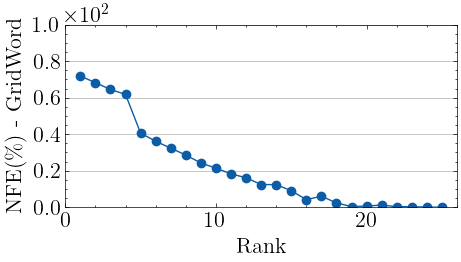

<Figure size 350x262.5 with 0 Axes>

In [3]:
from src.plots import plot_gridworld, plot_errors, plot_tensor_rank

plot_tensor_rank(Q_opt, None, 40)

POLICY EVALUATION WITH BCD

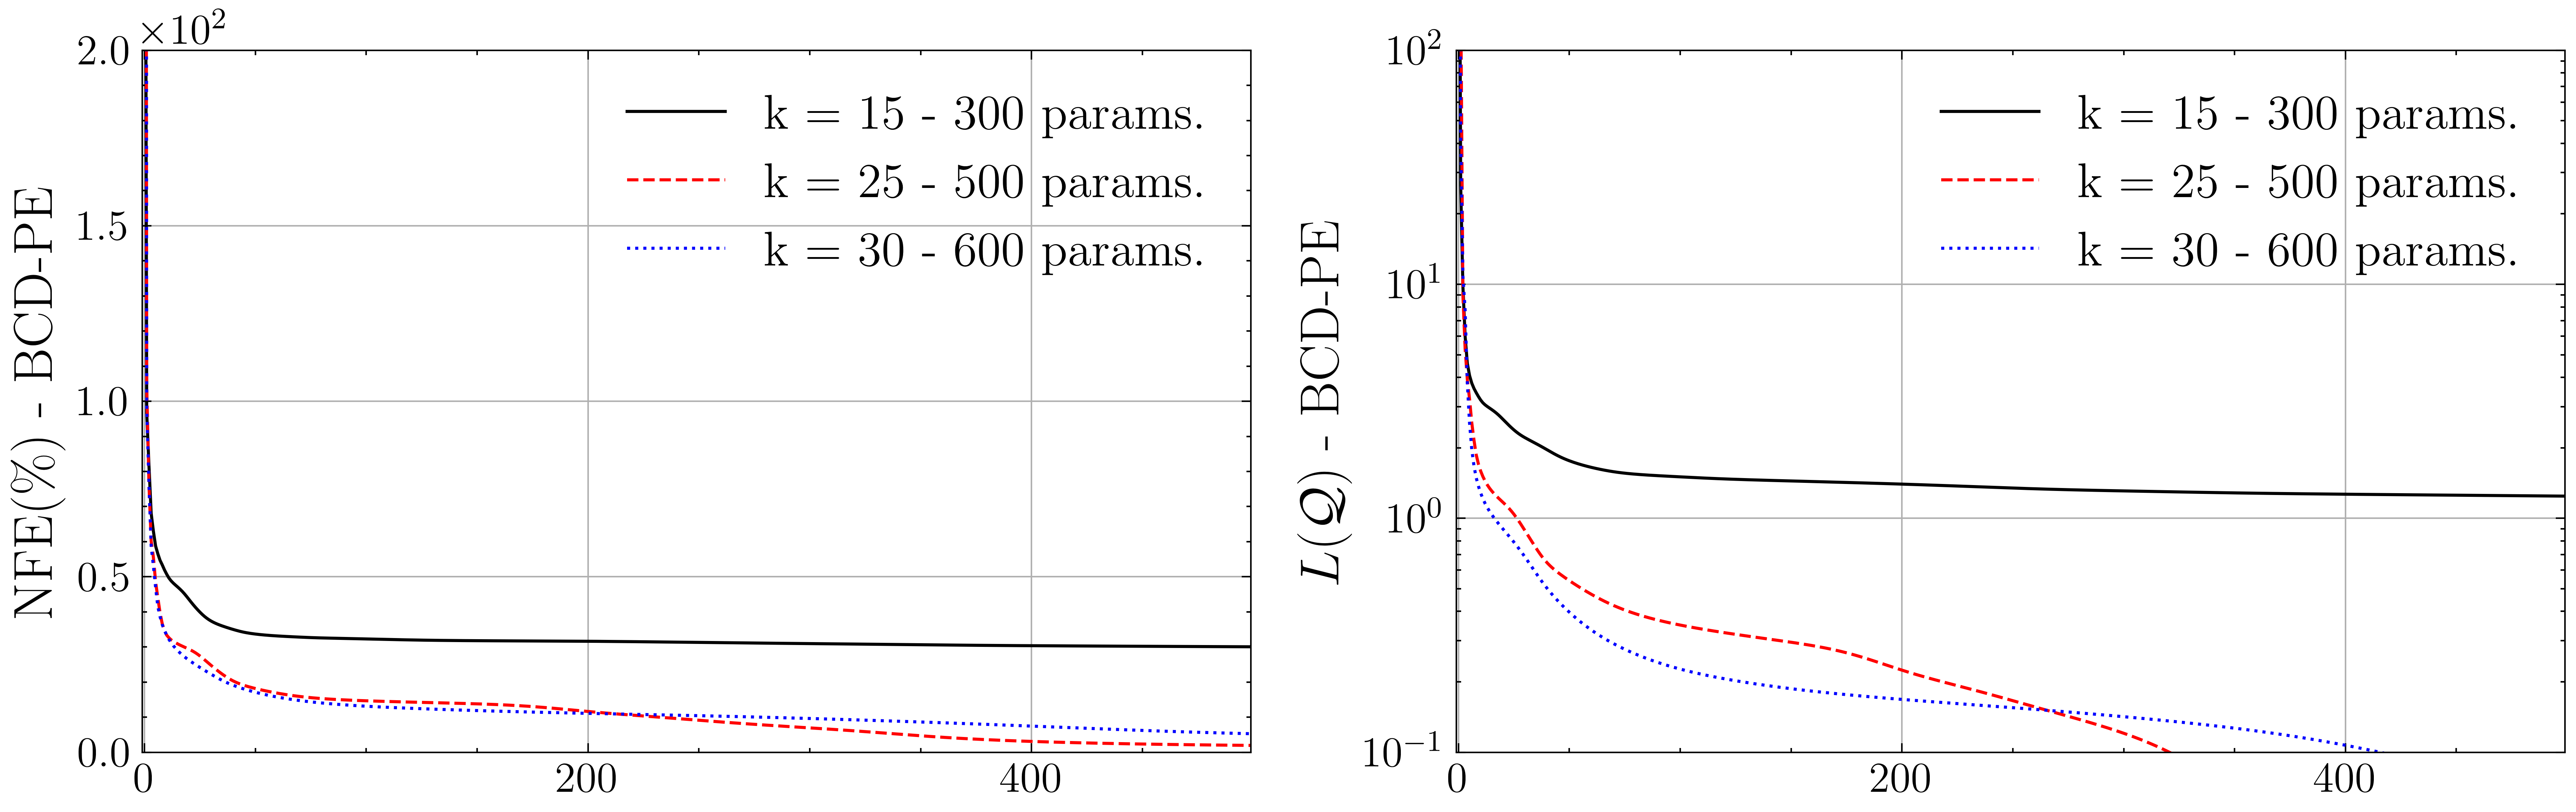

In [ ]:
with open('results/gridworld_bcd_pe.pkl', 'rb') as f:
    data = pickle.load(f) # deserialize using load()

fo_list = data[0]
errors_list = data[1]
conv_list = data[2]


k_list = [15, 25, 30]
num_iter = 500
# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 4])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[0].set_xlim(-1, num_iter-1)
        axes[0].set_ylim(0, 200)
        #axes[0].set_xlabel("(a) Iterations",fontsize=18)
        axes[0].set_ylabel("NFE(\%) - BCD-PE",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(fo_values ,label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[1].set_xlim(-1, num_iter-1)
        axes[1].set_ylim(0.1, 100)
        #axes[1].set_xlabel("(b) Iterations",fontsize=18)
        axes[1].set_ylabel(r"$ L (\mathcal{Q})$ - BCD-PE ",fontsize=18)
        axes[1].set_yscale('log')
        axes[1].legend(loc='upper right')
        axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.savefig("figures/BCD-PE")
    # Mostrar la figura
    plt.show()

POLICY EVALUATION WITH BCGD

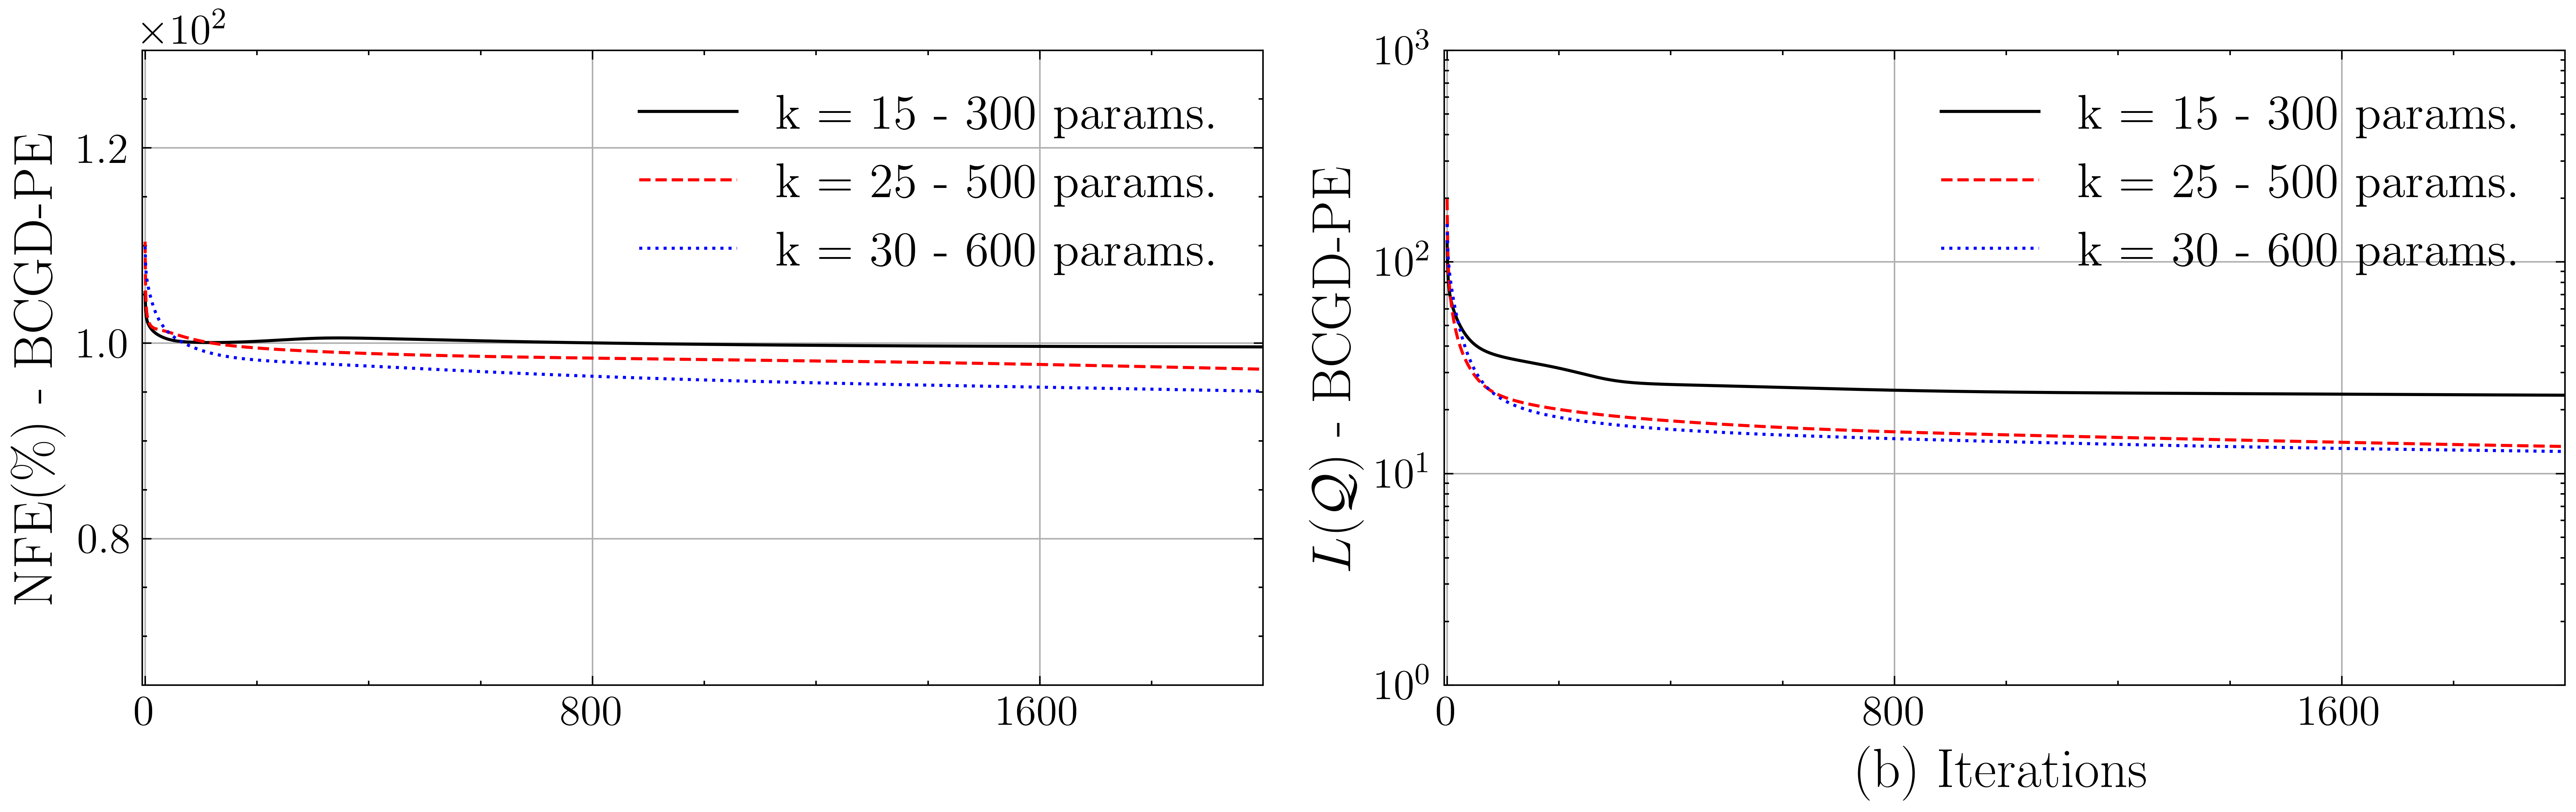

In [6]:
with open('results/gridworld_bcgd_pe.pkl', 'rb') as f:
    data = pickle.load(f) # deserialize using load()

fo_list = data[0]
errors_list = data[1]
conv_list = data[2]

k_list = [15, 25, 30]
num_iter = 2000

# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 4])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[0].set_xlim(-5, num_iter -1)
        axes[0].set_ylim(65, 130)
        #axes[0].set_xlabel("(a) Iterations",fontsize=18)
        axes[0].set_ylabel("NFE(\%) - BCGD-PE",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(fo_values ,label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[1].set_xlim(-5, num_iter-1)
        axes[1].set_ylim(1, 1000)
        axes[1].set_xlabel("(b) Iterations",fontsize=18)
        axes[1].set_ylabel(r"$ L (\mathcal{Q})$ - BCGD-PE",fontsize=18)
        axes[1].set_yscale('log')
        axes[1].legend(loc='upper right')
        axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.savefig("figures/BCGD-PE-vertical")
    # Mostrar la figura
    plt.show()

BCD - Policy Iteration

1.0


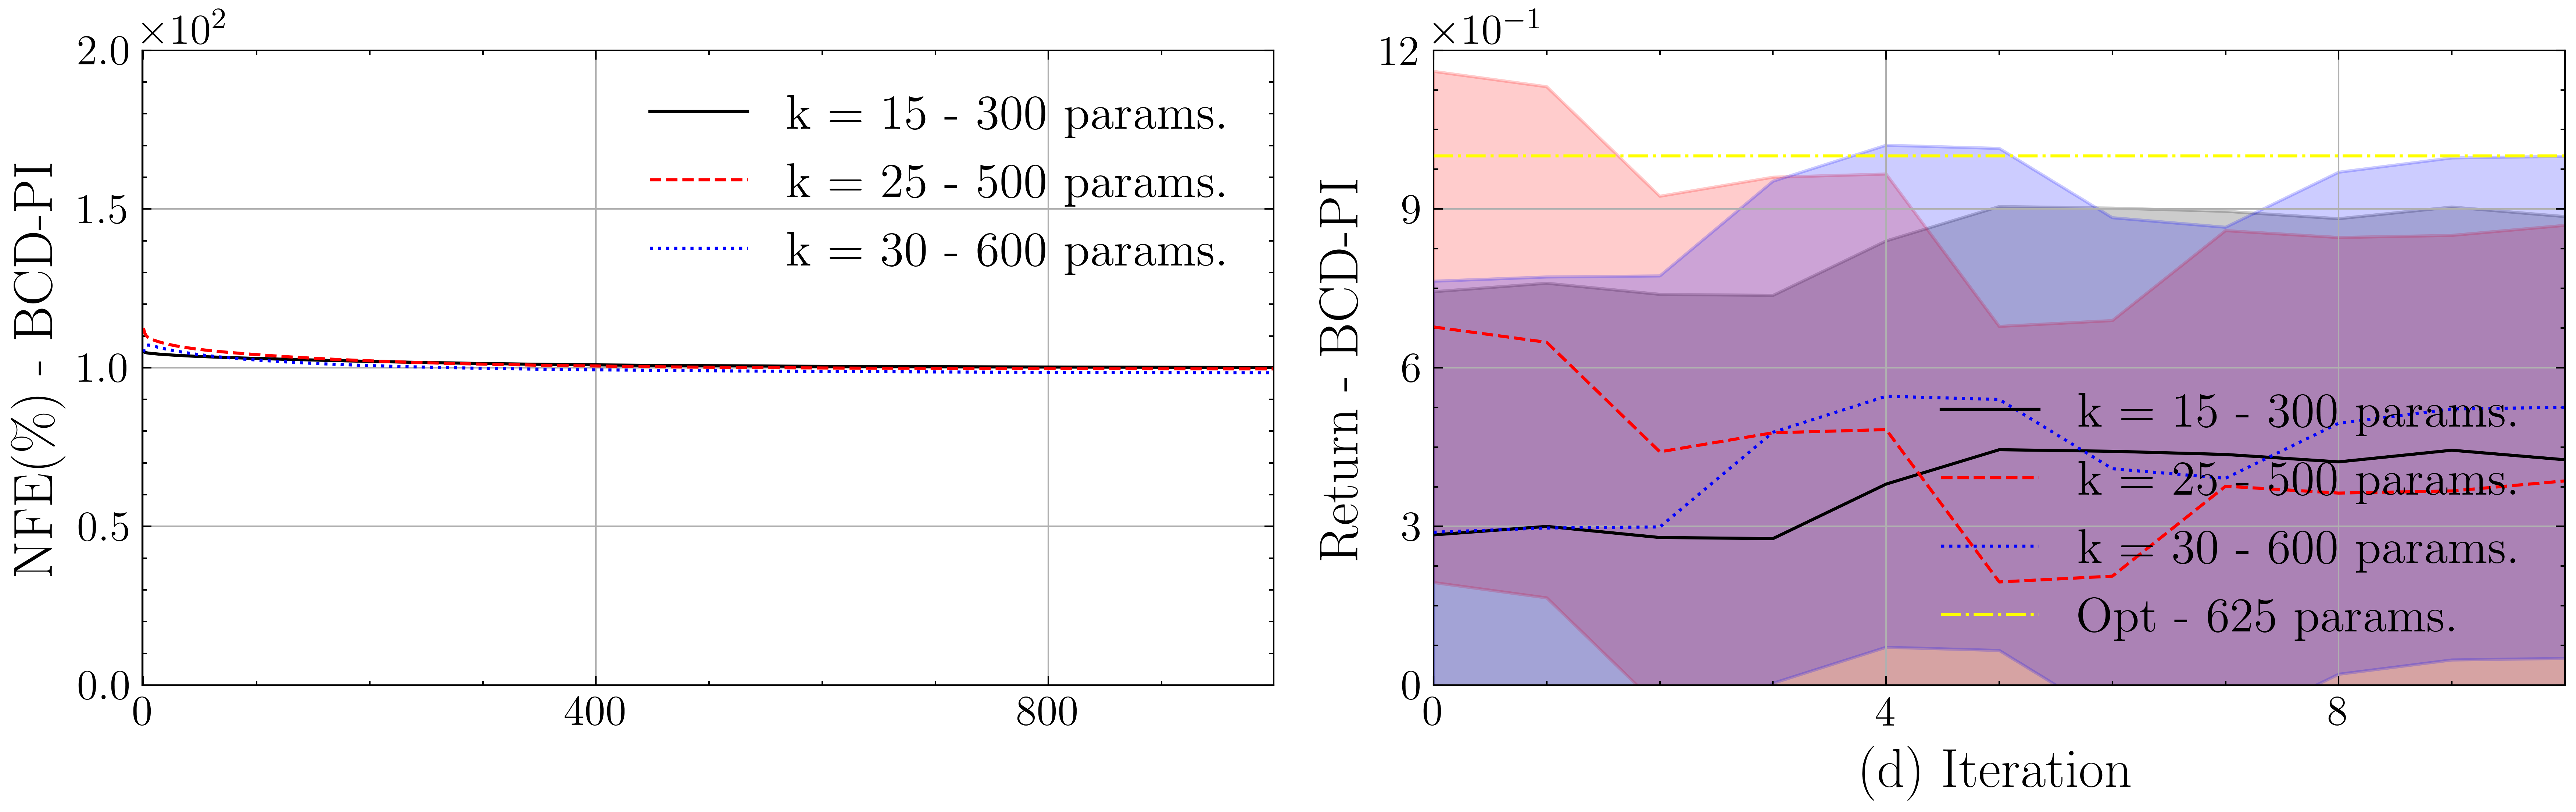

In [ ]:
with open('results/gridworld_bcd_pi.pkl', 'rb') as f:
    data = pickle.load(f) # deserialize using load()

fo_list = data[0]
errors_list = data[1]
conv_list = data[2]
returns_mean_list = data[3]
returns_std_list = data[4]

k_list = [15, 25, 30]
scale = 0.7
bcd_num_iter = 5
policy_num_iter = 100

G_list = []
Policy_opt = Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA)
for i in range(10000):
    G = 0
    s, _ = ENV.reset()
    for h in range(ENV.H):
        s1, s2 = s
        dist = Policy_opt[h, s2, s1,:]
        a = [np.argmax(dist)]
        s, r, d, _, _ = ENV.step(a)
        G += r

        if d:
            break
    G_list.append(G)

opt_mean_return = np.mean(G_list)
print(opt_mean_return)

colors = ["Black","Red","Blue","Green"]
x_lim = 0
for errors in errors_list:
    if len(errors) > x_lim:
        x_lim = len(errors)
# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 4])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]
        returns_mean = np.array(returns_mean_list[k])
        returns_std = np.mean(returns_std_list[k])

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),color = colors[k],label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[0].set_xlim(-1, x_lim -1)
        axes[0].set_ylim(0, 200)
        #axes[0].set_xlabel("(c) Iterations",fontsize=18)
        axes[0].set_ylabel("NFE(\%) - BCD-PI",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(returns_mean , color = colors[k], label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].fill_between(
            range(len(returns_mean)),  # Eje X: índices de los valores
            returns_mean - returns_std,  # Límite inferior
            returns_mean + returns_std,  # Límite superior
            color=colors[k], alpha=0.2  # Opcional: color y transparencia
        )
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[1].set_xlim(0, policy_num_iter - 1)
        axes[1].set_ylim(0, 1.2)
        #axes[1].set_xlabel("(d) Iterations",fontsize=18)
        axes[1].set_ylabel(r"Return - BCD-PI",fontsize=18)
        axes[1].legend(loc='lower right')
        axes[1].grid(True)
    
    # Tercer subplot: Tangente
    axes[1].plot([opt_mean_return]*policy_num_iter, color = "yellow", label = f"Opt - {Q_opt.size} params.")
    axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
    axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
    axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
    axes[1].set_xlim(0, 10)
    axes[1].set_ylim(0, 1.2)
    axes[1].set_xlabel("(d) Iteration",fontsize=18)
    axes[1].set_ylabel(r"Return - BCD-PI",fontsize=18)
    axes[1].legend(loc='lower right')
    axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.savefig("figures/BCD-PI")
    # Mostrar la figura
    plt.show()

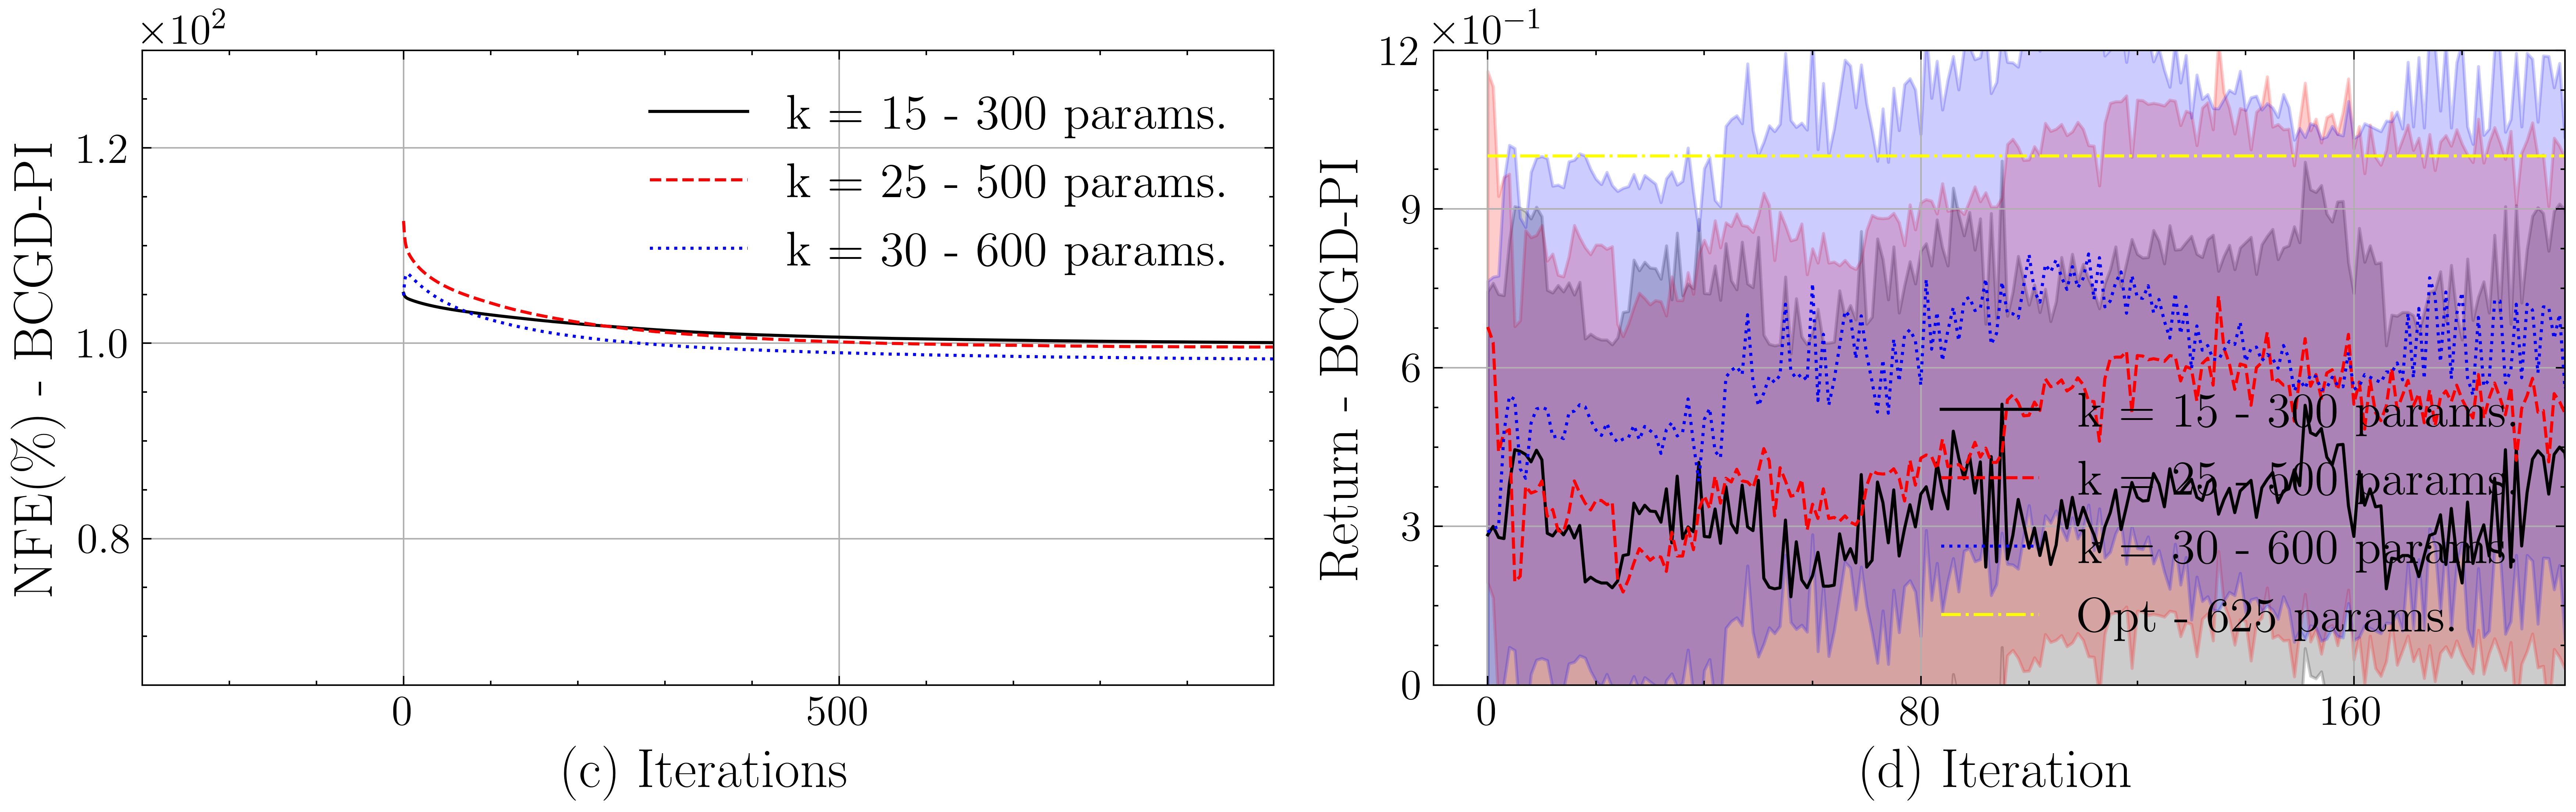

In [ ]:
with open('results/gridworld_bcgd_pi.pkl', 'rb') as f:

    data = pickle.load(f) # deserialize using load()

fo_list = data[0]
errors_list = data[1]
conv_list = data[2]
returns_mean_list = data[3]
returns_std_list = data[4]


k_list = [15, 25, 30]
scale = 0.5
bcd_num_iter = 5
policy_num_iter = 200
alpha = 10e-3

colors = ["Black","Red","Blue","Green"]
x_lim = 0
for errors in errors_list:
    if len(errors) > x_lim:
        x_lim = len(errors)
# Crear subplots
with plt.style.context(['science', 'ieee']):
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 4])
    plt.rc('legend', fontsize=16)    # legend fontsize

    for k in range(len(k_list)):
        fo_values = fo_list[k]
        errors = errors_list[k]
        convs = conv_list[k]
        returns_mean = np.array(returns_mean_list[k])
        returns_std = np.mean(returns_std_list[k])

        # Segundo subplot: Coseno
        axes[0].plot(errors/(np.linalg.norm(Q_opt)/100),color = colors[k],label = f"k = {k_list[k]} - {(ENV.W*2  + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[0].set_xlim(-300, x_lim -1)
        axes[0].set_ylim(65, 130)
        axes[0].set_xlabel("(c) Iterations",fontsize=18)
        axes[0].set_ylabel("NFE(\%) - BCGD-PI",fontsize=18)
        axes[0].legend(loc='upper right')
        axes[0].grid(True)

        # Tercer subplot: Tangente
        axes[1].plot(returns_mean , color = colors[k], label = f"k = {k_list[k]} - {(ENV.W*2 + ENV.nA + ENV.H)*k_list[k] } params.")
        axes[1].fill_between(
            range(len(returns_mean)),  # Eje X: índices de los valores
            returns_mean - returns_std,  # Límite inferior
            returns_mean + returns_std,  # Límite superior
            color=colors[k], alpha=0.2  # Opcional: color y transparencia
        )
        axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
        axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
        axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
        axes[1].set_xlim(-1, policy_num_iter - 1)
        axes[1].set_ylim(0, 1.2)
        axes[1].set_xlabel("(d) Iterations",fontsize=18)
        axes[1].set_ylabel(r"Return  - BCGD-PI",fontsize=18)
        axes[1].legend(loc='upper right')
        axes[1].grid(True)
    
    # Tercer subplot: Tangente
    axes[1].plot([opt_mean_return]*policy_num_iter , color = 'yellow', label = f"Opt - {Q_opt.size} params.")
    axes[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
    axes[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
    axes[1].xaxis.set_major_locator(MaxNLocator(nbins=3))
    axes[1].set_xlim(-10, policy_num_iter - 1)
    axes[1].set_ylim(0, 1.2)
    axes[1].set_xlabel("(d) Iteration",fontsize=18)
    axes[1].set_ylabel(r"Return - BCGD-PI ",fontsize=18)
    axes[1].legend(loc='lower right')
    axes[1].grid(True)

    # Ajustar el espacio entre subplots
    plt.tight_layout()
    plt.savefig("figures/BCGD-PI")
    # Mostrar la figura
    plt.show()
    

In [ ]:
from src.plots import crear_mosaico

# Lista de imágenes
fotos = ["figures/BCD-PE.png", "figures/BCD-PI.png", "figures/BCGD-PE.png", "figures/BCGD-PI.png"]

# Crear mosaico
crear_mosaico(fotos,"figures/prueba.png")


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


Plot de las matrices

In [ ]:
Tamaño = 5

ENV = GridWorldEnv(nS =Tamaño*Tamaño,W = Tamaño, H = Tamaño,nA=5)

DISCRETIZER = Discretizer(
    min_points_states=[0, 0],
    max_points_states=[4, 4],
    bucket_states=[5, 5],
    min_points_actions=[0],
    max_points_actions=[4],
    bucket_actions=[5],
)

bp_learner = BackwardPropagation(ENV.H,ENV.nS,ENV.nA,ENV.R,ENV.P)
_ = bp_learner.run()
Q_opt =  bp_learner.Q

k = 50
scale = 0.7
bcd_num_iter = 5
policy_num_iter = 100

Q = PARAFAC(
        np.concatenate(
            [[ENV.H], DISCRETIZER.bucket_states, DISCRETIZER.bucket_actions]
        ),
        k=k,
        scale= scale,
        nA=len(DISCRETIZER.bucket_actions),
).double()

Pi = np.zeros((ENV.H,ENV.nS, ENV.nA))
for h in range(ENV.H):
    for s in range(ENV.nS):
        #a = np.argmax(Q.forward(np.array([h, s])).detach().numpy())
        a = np.argmax(Q_opt[h,s,:])
        Pi[h,s, a] = 1

clasic = ClassicDP(ENV.nS,ENV.nA,ENV.R,ENV.P,gamma = 1)
bcd_inv = bcd(Q,Pi,DISCRETIZER,ENV,k,Q_opt.reshape(ENV.H,ENV.W,ENV.W,ENV.nA))

_ = clasic.run_value_iter()
_,_,_,_,_, Q = bcd_inv.bcd_policy_improvement(policy_num_iter,bcd_num_iter)

from src.plots import plot_gridworld

mat_classic = np.max(clasic.Q, axis=1).reshape(ENV.W,ENV.W)
mat_dp = np.max(bp_learner.Q[3,:], axis=1).reshape(ENV.W,ENV.W)
mat_pi = np.max(tl.cp_to_tensor(([1]*k,[factor.detach().numpy() for factor in Q.factors])),axis=3)[3].reshape(ENV.W, ENV.W)

Q_clasic = np.transpose(clasic.Q.reshape(ENV.W,ENV.W,ENV.nA),[1,0,2])
Q_bp = np.transpose(bp_learner.Q[3,:].reshape(ENV.W,ENV.W,ENV.nA),[1,0,2])
Q_pi = np.round(np.transpose(tl.cp_to_tensor(([1]*k,[factor.detach().numpy() for factor in Q.factors]))[3,:],[1,0,2]),2)

plot_gridworld(ENV.W, mat_classic, mat_dp, mat_pi,[Q_clasic,Q_bp,Q_pi])